# Castañas

En este documento se va a crear un modelo para las castañas para su posterior análisis con XAI

## Carga de datos ya aumentados

In [1]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np

2025-05-27 01:19:02.433440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748308742.617228      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748308742.666421      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [55]:
dataset_dir = '/kaggle/input/castanas-aug-ds/castanas_aug_ds'

train, val = keras.utils.image_dataset_from_directory (
    directory=dataset_dir,
    batch_size=34,
    shuffle=True,
    labels="inferred" ,
    class_names= ["no_comible", "comible"],
    label_mode='binary',
    color_mode='rgb',
    image_size=(256,256),
    validation_split=0.2,
    subset='both',
    seed=69,
    )


Found 2186 files belonging to 2 classes.
Using 1749 files for training.
Using 437 files for validation.


In [ ]:
def ver_imgs(dataset: tf.data.Dataset):
    clases = ['no comible', 'comible']
    plt.figure(figsize=(5,5))
    # plt.subplots_adjust(hspace=10)

    imgs, labels = next(iter(dataset.take(1)))

    for i in range(3):
        img, label = imgs[i], labels[i]
        ax = plt.subplot(1,3,i+1)
        ax.set_axis_off()
        plt.imshow( img.numpy().astype('uint8') )
        plt.title ( clases[int(label.numpy()[0])])


    plt.tight_layout()
    plt.show()
        

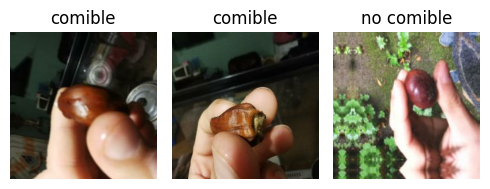

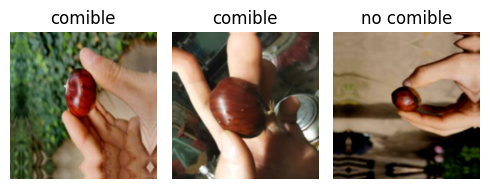

In [4]:
ver_imgs(train)
ver_imgs(val)

## hyper-parámetros

In [56]:
# lr = 5e-5
lr = 0.005166626535356045
batch_size = 34

## Modelo CNN

In [6]:
modificar_img = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
    keras.layers.RandomContrast(0.2)
])

In [7]:
def get_model(lr):
    model = keras.Sequential([
        keras.Input(shape=(256, 256, 3)),
        keras.layers.Rescaling(1./255),
        modificar_img, 
        #1
        #agregado kernel_regularizer=keras.regularizers.l2(0.001)
        keras.layers.Conv2D( filters=32, kernel_size=(5,5)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #2
        keras.layers.Conv2D( filters=64, kernel_size=(7,7)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #3
        keras.layers.Conv2D( filters=64, kernel_size=(3,3)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #4
        keras.layers.Conv2D( filters=64, kernel_size=(3,3)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #5
        keras.layers.Conv2D( filters=64, kernel_size=(3,3)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
    
        #agregado drop 0.2->0.4, kernel_regularizer=keras.regularizers.l2(0.001)
        keras.layers.Flatten(),
        #1
        keras.layers.Dense(units= 128),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.4) ,
        #2
        keras.layers.Dense(units= 64),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.2) ,
        #3
        keras.layers.Dense(units= 32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.2) ,
        keras.layers.Dense(units= 1, activation='sigmoid'),
    ],
    trainable=True,
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr ),
        # optimizer='adam',
        loss=keras.losses.binary_crossentropy,
        metrics=['accuracy'],
    )

    return model

In [8]:
model_v = get_model(lr)
model_v.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 252, 252, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 252, 252, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 252, 252, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 120, 64)        │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 120, 120, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 58, 58, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 430,977 (1.64 MB)

 Trainable params: 429,953 (1.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Ecnontrar el LR inicial óptimo

In [9]:
!pip install git+https://github.com/JonnoFTW/keras_lr_finder.git

  Cloning https://github.com/JonnoFTW/keras_lr_finder.git to /tmp/pip-req-build-1nrl0pzu
  Running command git clone --filter=blob:none --quiet https://github.com/JonnoFTW/keras_lr_finder.git /tmp/pip-req-build-1nrl0pzu
  Resolved https://github.com/JonnoFTW/keras_lr_finder.git to commit e57a5526e913ba545fa0d7390fa1be5e18d2d305
  Preparing metadata (setup.py) ... done
  Created wheel for keras_lr_finder: filename=keras_lr_finder-0.1-py3-none-any.whl size=3970 sha256=9c21745126a64e79e86a5f0d1857a640df20b832e956e317c8b13bbe49313e01
  Stored in directory: /tmp/pip-ephem-wheel-cache-z2r67h7s/wheels/ec/cb/56/0a8cb1583f352bfeb4a6e81dcf6f83f3c5bfc1de27dea96c13
Successfully built keras_lr_finder


In [10]:
from keras_lr_finder import LRFinder


X_train_list = []
y_train_list = []

for images, labels in train:
    X_train_list.append(images.numpy())
    y_train_list.append(labels.numpy())

# Convertir a arrays
x_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)


In [36]:
model1 = get_model(lr)
lr_finder1 = LRFinder(model1)
lr_finder1.find(x_train, y_train,
               start_lr=1e-6, end_lr=2,
               batch_size=128, epochs=5)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 404ms/step - accuracy: 0.4204 - loss: 0.9100
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.4084 - loss: 0.9419
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.4903 - loss: 0.8454
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.7637 - loss: 0.4897
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.7630 - loss: 0.4683


0.02161245606839657


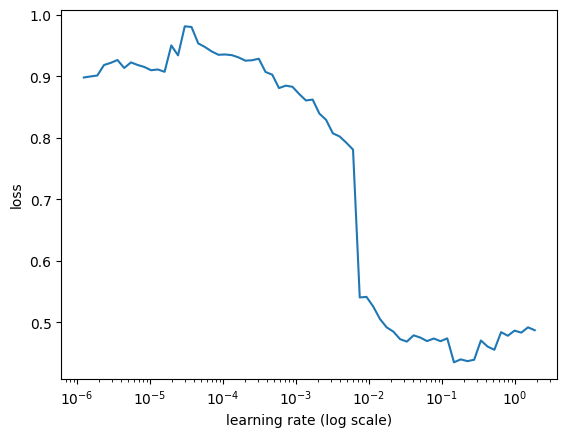

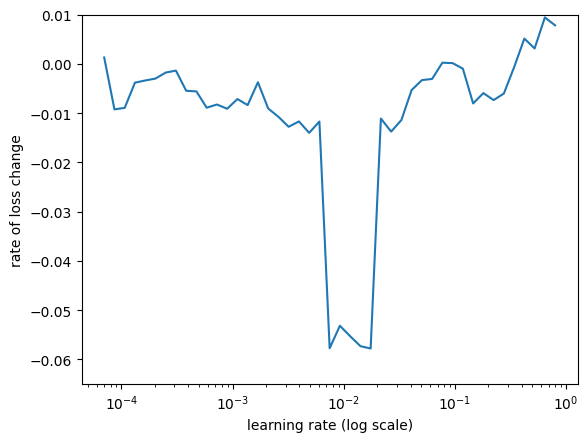

In [47]:
print(lr_finder1.get_best_lr(sma=20, n_skip_beginning=20, n_skip_end=5))
lr_finder1.plot_loss(n_skip_beginning=1, n_skip_end=1)
lr_finder1.plot_loss_change(sma=5, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.065, 0.01))

In [38]:
model2 = get_model(lr)
lr_finder2 = LRFinder(model2)
lr_finder2.find(x_train, y_train,
               start_lr=1e-12, end_lr=2,
               batch_size=32, epochs=5)

Epoch 1/5


E0000 00:00:1748286564.198107      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_17_1/dropout_128_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.3693 - loss: 1.1057
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.3957 - loss: 1.0808
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4125 - loss: 1.0476
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4242 - loss: 1.0472
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.7727 - loss: 0.4869


0.016512006521224976


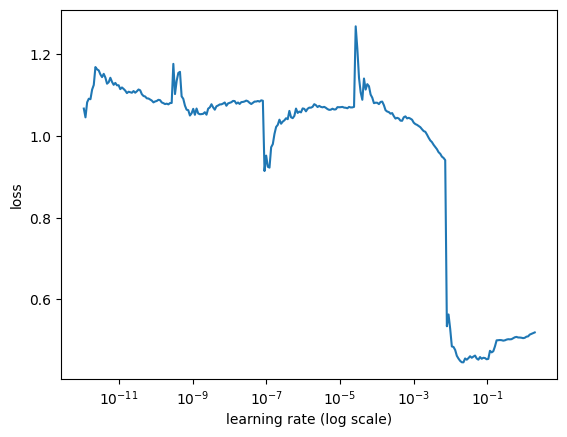

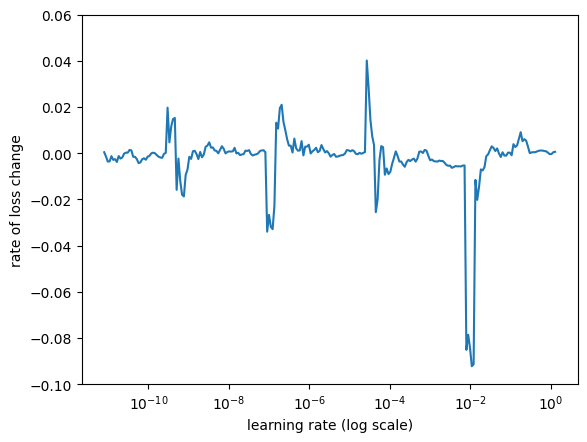

In [45]:
print(lr_finder2.get_best_lr(sma=20, n_skip_beginning=20, n_skip_end=5))
lr_finder2.plot_loss(n_skip_beginning=1, n_skip_end=1)
lr_finder2.plot_loss_change(sma=5, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.1, 0.06))

In [40]:
model3 = get_model(lr)
lr_finder3 = LRFinder(model3)
lr_finder3.find(x_train, y_train,
               start_lr=1e-12, end_lr=2,
               batch_size=215, epochs=5)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - accuracy: 0.6058 - loss: 0.7324
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 608ms/step - accuracy: 0.6174 - loss: 0.7155
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 607ms/step - accuracy: 0.5971 - loss: 0.7249
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step - accuracy: 0.6335 - loss: 0.6626
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 602ms/step - accuracy: 0.6552 - loss: 0.8301


0.6232187151908875


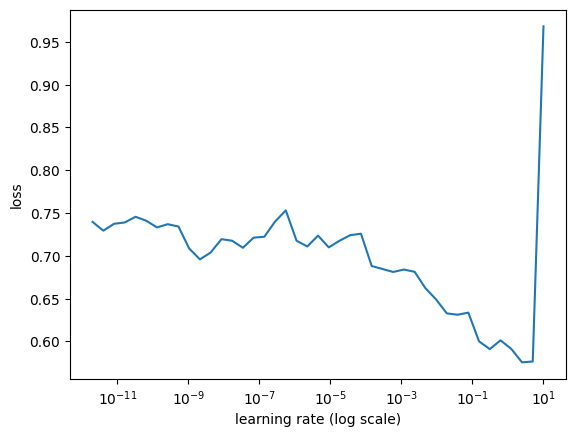

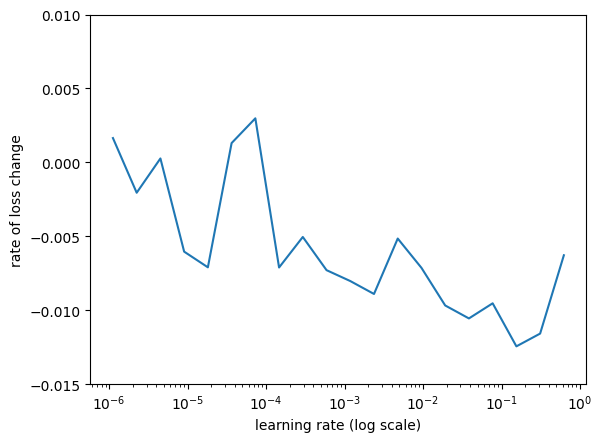

In [48]:
print(lr_finder3.get_best_lr(sma=20, n_skip_beginning=20, n_skip_end=5))
lr_finder3.plot_loss(n_skip_beginning=1, n_skip_end=1)
lr_finder3.plot_loss_change(sma=5, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.015, 0.01))

In [11]:
model1 = get_model(lr)
lr_finder1 = LRFinder(model1)
lr_finder1.find(x_train, y_train,
               start_lr=1e-6, end_lr=1,
               batch_size=164, epochs=5)

Epoch 1/5


E0000 00:00:1748308843.245256      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1748308846.050561     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5022 - loss: 0.7722 
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step - accuracy: 0.5142 - loss: 0.7570
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - accuracy: 0.5376 - loss: 0.7369
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.7382 - loss: 0.5269
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step - accuracy: 0.7527 - loss: 0.4461


0.005166626535356045


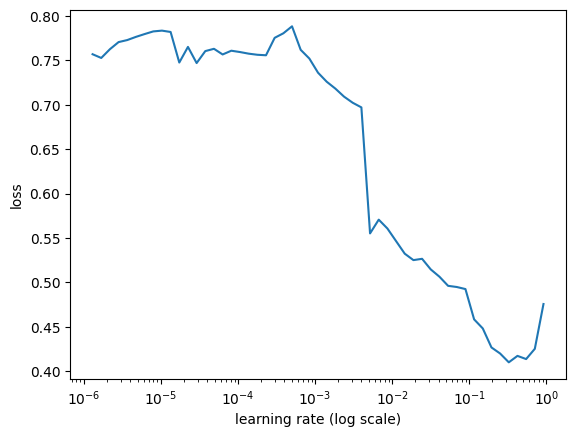

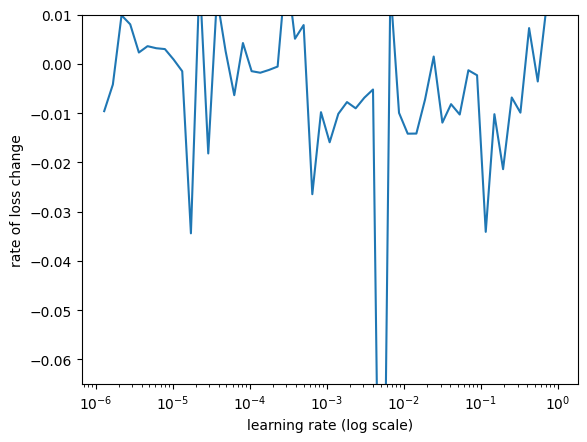

In [44]:
print(lr_finder1.get_best_lr(sma=1, n_skip_beginning=1, n_skip_end=1))
lr_finder1.plot_loss(n_skip_beginning=1, n_skip_end=1)
lr_finder1.plot_loss_change(sma=1, n_skip_beginning=1, n_skip_end=1, y_lim=(-0.065, 0.01))

## Ajustar LR dinámicamente

In [14]:
import math

class TriangularExponentialDecay(tf.keras.callbacks.Callback):
    # https://arxiv.org/abs/1506.01186?ref=jeremyjordan.me
    # https://www.jeremyjordan.me/nn-learning-rate/
    def __init__(self, max_lr, min_lr, steps_per_cycle, decay=0.9):
        super().__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.steps_per_cycle = steps_per_cycle
        self.decay = decay
        self.step = 0
        self.lr_history = []

    def on_train_batch_begin(self, batch, logs=None):
        cycle_position = self.step % self.steps_per_cycle
        cycle_fraction = cycle_position / self.steps_per_cycle

        if cycle_fraction <= 0.5:
            lr = self.min_lr + (self.max_lr - self.min_lr) * (cycle_fraction * 2)
        else:
            lr = self.max_lr - (self.max_lr - self.min_lr) * ((cycle_fraction - 0.5) * 2)

        # Apply exponential decay
        decay_factor = self.decay ** (self.step // self.steps_per_cycle)
        lr *= decay_factor

        self.model.optimizer.learning_rate.assign(lr)
        self.lr_history.append(lr)
        self.step += 1
        
    def plot(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.lr_history, label="Learning Rate")
        plt.xlabel("Training Step")
        plt.ylabel("Learning Rate")
        plt.title("Triangular Exponential Decay Schedule")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
# steps_per_epoch = cantidad de datos de entrenamiento // batch size
steps_per_epoch = 1749 // batch_size
# lr_n = 0.001660758216205174 curioso que al multiplixarlo por 5 como lo estaba haciendo da cerca del mejor valor de lr inicial
scheduler_lr = TriangularExponentialDecay(
    max_lr= 1.2*lr,
    min_lr= 0.8*lr ,
    steps_per_cycle=2 * steps_per_epoch,
    decay=0.8
)

# def scheduler(epoch, lr):
#     lr = 
#     lr = min(1e-2, lr)
#     lr = max(4e-04, lr)
    
# lr_sheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

## Early stopping

In [39]:
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 8,
    min_delta=0.001,
    restore_best_weights = True,
    )

## Entrenamiento

In [58]:
print(f'{lr} {5*0.001660758216205174} {0.1*0.001660758216205174} {0.00830379108102587/lr}')
model = get_model(lr)

0.005166626535356045 0.00830379108102587 0.0001660758216205174 1.6071978541901006


In [ ]:
history = model.fit(
    train,
    epochs=40, 
    validation_data=val,
    callbacks = [early_stop, scheduler_lr],
    # callbacks = [early_stop],
    class_weight={0: 1.5, 1: 1.0},
)

Epoch 1/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.8771 - loss: 0.3468 - val_accuracy: 0.7689 - val_loss: 1.6020
Epoch 2/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.8684 - loss: 0.3663 - val_accuracy: 0.8787 - val_loss: 0.2596
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.8974 - loss: 0.3310 - val_accuracy: 0.8535 - val_loss: 0.4300
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9088 - loss: 0.2863 - val_accuracy: 0.6659 - val_loss: 0.9370
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9030 - loss: 0.2677 - val_accuracy: 0.5629 - val_loss: 1.3140
Epoch 6/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9045 - loss: 0.2643 - val_accuracy: 0.7391 - val_loss: 0.6185
Epoch 7/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9142 - loss: 0.2485 - val_accuracy: 0.8444 - val_loss: 0.3337
Epoch 8/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9161 - loss: 0.2322 - val_accuracy: 0.

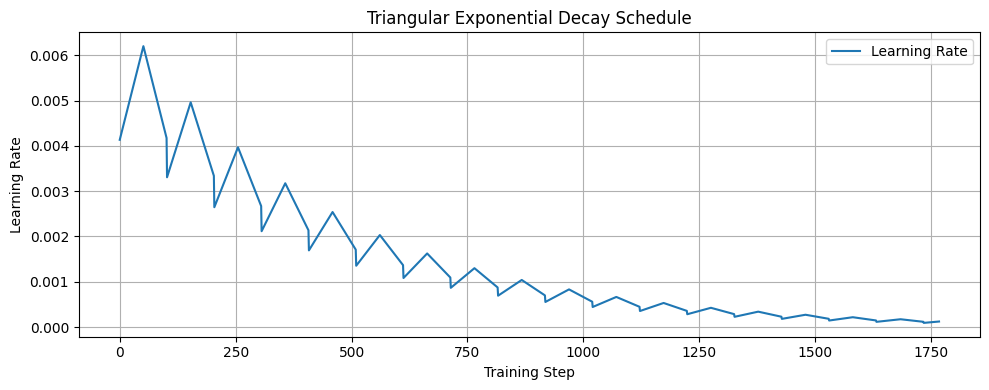

In [64]:
scheduler_lr.plot()

In [ ]:
!mkdir -p "/kaggle/working/modelos/"
model.save("/kaggle/working/modelos/Castanas_Model_97.keras")

13/13 - 0s - 26ms/step - accuracy: 0.9725 - loss: 0.0646
val accuaricy: 0.972540020942688 val loss: 0.0645570158958435


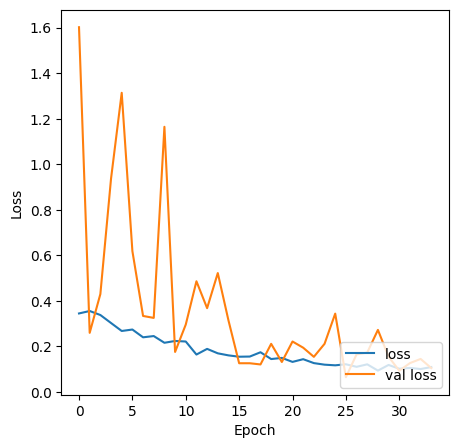

In [65]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(val, verbose=2)
print(f'val accuaricy: {val_acc} val loss: {val_loss}')